In [27]:
# Standard python libraries
from pathlib import Path
import os
import requests
import pickle
import matplotlib.pyplot as plt
# Essential DS libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from copy import copy
import xgboost as xgb
import lightgbm as lgb
from clearml import Dataset

import time

from ipywidgets import interact

import shap
shap.initjs()

# LightAutoML presets, task and report generation
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task
from lightautoml.reader.base import PandasToPandasReader
from lightautoml.ml_algo.boost_lgbm import BoostLGBM
from lightautoml.pipelines.ml.base import MLPipeline
from lightautoml.automl.base import AutoML

from lightautoml.addons.interpretation import SSWARM

In [ ]:
N_THREADS = 8
RANDOM_STATE = 77
N_FOLDS = 3


In [37]:
boost_params = {
"task": "train",
"learning_rate": 0.05,
"num_leaves": 128,
"feature_fraction": 0.7,
"bagging_fraction": 0.7,
"bagging_freq": 1,
"max_depth": -1,
"verbosity": -1,
"reg_alpha": 1,
"reg_lambda": 0.0,
"min_split_gain": 0.0,
"zero_as_missing": False,
"num_threads": 4,
"max_bin": 255,
"min_data_in_bin": 3,
"num_trees": 3000,
"early_stopping_rounds": 100,
"random_state": 42,
# "metric" : "binary_logloss",
"objective": "binary",
    
}

In [38]:
def check_perfomance_on_datasets(X, y, task_type):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=77)

    df_train = X_train.assign(target=y_train).reset_index(drop=True)
    df_test = X_test.assign(target=y_test).reset_index(drop=True)

    task = Task(task_type)
    roles = {'target': "target"}
    automl = TabularAutoML(
        task = task, 
        timeout = 200,
        cpu_limit = N_THREADS,
        reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
    )
    automl.fit_predict(df_train, roles = roles, verbose = 1)

    def f(X):
        return automl.predict(X, features_names=X_train.columns).data[:, -1].flatten()

    start = time.time()
    explainer = shap.KernelExplainer(f, X_test.iloc[:50])
    shap_values = explainer.shap_values(X_test.iloc[51:54])
    time_kernel = (time.time() - start) / 3 * X_test.shape[0]

    X_train_temp = X_train.select_dtypes(include=['int', "float"])
    X_test_temp = X_test.select_dtypes(include=['int', "float"])
    d_train = lgb.Dataset(X_train_temp, label=y_train)
    d_val = lgb.Dataset(X_test_temp.iloc[:50], label=y_test[:50])
    model = lgb.train(params=boost_params, train_set=d_train, valid_sets=[d_val])

    start = time.time()
    explainer_default = shap.TreeExplainer(model)
    shap_values_tree = explainer_default.shap_values(X_test_temp)
    time_tree = time.time() - start
    print(time_tree / X_test.shape[0])

    start = time.time()
    explainer_sswarm = SSWARM(automl, random_state=RANDOM_STATE)
    shap_values_sswarm = explainer_sswarm.shap_values(X_test, n_repeats=1, n_jobs=N_THREADS)
    time_sswarm = time.time() - start

    print(time_kernel, time_tree, time_sswarm)
    return time_kernel / X_test.shape[0], time_tree / X_test.shape[0], time_sswarm / X_test.shape[0]

    

In [8]:
# adults dataset
X, y = shap.datasets.adult()
y = y.astype(int)
time_kernel, time_tree, time_sswarm = check_perfomance_on_datasets(X, y, "binary")

[06:30:17] Stdout logging level is INFO.
[06:30:17] Task: binary

[06:30:17] Start automl preset with listed constraints:
[06:30:17] - time: 100.00 seconds
[06:30:17] - CPU: 8 cores
[06:30:17] - memory: 16 GB

[06:30:17] Train data shape: (24420, 13)

[06:30:22] Layer 1 train process start. Time left 95.72 secs


  2%|█▉                                                                                           | 61/3000 [00:19<00:24, 118.95it/s]

[06:30:24] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[06:30:28] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.9249937849768656
[06:30:28] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[06:30:28] Time left 89.51 secs

[06:30:29] Selector_LightGBM fitting and predicting completed
[06:30:32] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[06:30:35] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.9263634428574765
[06:30:35] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[06:30:35] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 4.06 secs
[06:30:42] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
[06:30:42] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
[06:30:47] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = 0.9247375317699885
[06:30:47] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
[06:30:47] Start fitting Lvl_0_Pipe_1_Mod_2_Cat

  0%|          | 0/3 [00:00<?, ?it/s]

Found `num_trees` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[1]	valid_0's binary_logloss: 0.568196
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.538907
[3]	valid_0's binary_logloss: 0.518002
[4]	valid_0's binary_logloss: 0.49517
[5]	valid_0's binary_logloss: 0.475827
[6]	valid_0's binary_logloss: 0.461322
[7]	valid_0's binary_logloss: 0.449748
[8]	valid_0's binary_logloss: 0.433651
[9]	valid_0's binary_logloss: 0.418478
[10]	valid_0's binary_logloss: 0.405532
[11]	valid_0's binary_logloss: 0.392478
[12]	valid_0's binary_logloss: 0.381112
[13]	valid_0's binary_logloss: 0.3735
[14]	valid_0's binary_logloss: 0.364644
[15]	valid_0's binary_logloss: 0.356451
[16]	valid_0's binary_logloss: 0.348396
[17]	valid_0's binary_logloss: 0.342518
[18]	valid_0's binary_logloss: 0.33408
[19]	valid_0's binary_logloss: 0.32662
[20]	valid_0's binary_logloss: 0.321734
[21]	valid_0's binary_logloss: 0.317219
[22]	valid_0's binary_logloss: 0.313403
[23]	valid_0's binary_logloss: 0.308143
[24]	valid_0's binary_logloss: 0

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray

 95%|████████████████████████████████████████████████████████████████████████████████████████▎    | 950/1000 [01:43<00:05,  9.14it/s]

93699.04675372441 6.213386535644531 105.03591561317444


In [25]:
# california dataset
X, y = shap.datasets.california()
time_kernel, time_tree, time_sswarm = check_perfomance_on_datasets(X, y, "reg")

[06:40:27] Stdout logging level is INFO.
[06:40:27] Task: reg

[06:40:27] Start automl preset with listed constraints:
[06:40:27] - time: 100.00 seconds
[06:40:27] - CPU: 8 cores
[06:40:27] - memory: 16 GB

[06:40:27] Train data shape: (15480, 9)

[06:40:32] Layer 1 train process start. Time left 95.73 secs
[06:40:32] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[06:40:33] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -0.4476260450821314
[06:40:33] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[06:40:33] Time left 94.48 secs

[06:40:36] Selector_LightGBM fitting and predicting completed
[06:40:37] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[06:40:44] Time limit exceeded after calculating fold 1

[06:40:44] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -0.21160034880859965
[06:40:44] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[06:40:44] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 1.00 se

  0%|          | 0/3 [00:00<?, ?it/s]

Found `num_trees` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[1]	valid_0's l2: 0.716476
Training until validation scores don't improve for 100 rounds
[2]	valid_0's l2: 0.669678
[3]	valid_0's l2: 0.627052
[4]	valid_0's l2: 0.589461
[5]	valid_0's l2: 0.551804
[6]	valid_0's l2: 0.516639
[7]	valid_0's l2: 0.486217
[8]	valid_0's l2: 0.451424
[9]	valid_0's l2: 0.425646
[10]	valid_0's l2: 0.397458
[11]	valid_0's l2: 0.367723
[12]	valid_0's l2: 0.343975
[13]	valid_0's l2: 0.324528
[14]	valid_0's l2: 0.304881
[15]	valid_0's l2: 0.289767
[16]	valid_0's l2: 0.27646
[17]	valid_0's l2: 0.261924
[18]	valid_0's l2: 0.250115
[19]	valid_0's l2: 0.239082
[20]	valid_0's l2: 0.22908
[21]	valid_0's l2: 0.218629
[22]	valid_0's l2: 0.211635
[23]	valid_0's l2: 0.20212
[24]	valid_0's l2: 0.194469
[25]	valid_0's l2: 0.188703
[26]	valid_0's l2: 0.181437
[27]	valid_0's l2: 0.175488
[28]	valid_0's l2: 0.170902
[29]	valid_0's l2: 0.16645
[30]	valid_0's l2: 0.162185
[31]	valid_0's l2: 0.157941
[32]	valid_0's l2: 0.153579
[33]	valid_0's l2: 0.152785
[34]	valid_0's l2: 0.147826


 97%|█████████████████████████████████████████████████████████████████████████████████████████▊   | 966/1000 [01:03<00:02, 15.13it/s]

6308.184509277344 19.9399676322937 64.71948385238647


In [5]:
# credit card fraud
dataset = Dataset.get(dataset_project="Datasets_with_metadata",
                          dataset_name="creditcard_fraud", dataset_version="9")
dataset_local_path = dataset.get_local_copy()

with open(os.path.join(dataset_local_path, "task_type.txt"), "r") as f:
    task_type = f.readline()
        
 
    
train = pd.read_csv(os.path.join(dataset_local_path, "train.csv"))
test = pd.read_csv(os.path.join(dataset_local_path, "test.csv"))

time_kernel, time_tree, time_sswarm = check_perfomance_on_datasets(train.drop(columns="Class"), train["Class"], "binary")

[06:50:13] Stdout logging level is INFO.
[06:50:13] Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer
[06:50:13] Task: binary

[06:50:13] Start automl preset with listed constraints:
[06:50:13] - time: 100.00 seconds
[06:50:13] - CPU: 8 cores
[06:50:13] - memory: 16 GB

[06:50:13] Train data shape: (28493, 22)

[06:50:18] Layer 1 train process start. Time left 95.37 secs
[06:50:18] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[06:50:23] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.985525758985152
[06:50:23] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[06:50:23] Time left 90.73 secs

[06:50:29] Selector_LightGBM fitting and predicting completed
[06:50:29] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[06:50:37] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.9998711487584825
[06:50:37] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[06:50:37] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...


  0%|          | 0/3 [00:00<?, ?it/s]

Found `num_trees` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[1]	valid_0's binary_logloss: 0.654051
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.619278
[3]	valid_0's binary_logloss: 0.58574
[4]	valid_0's binary_logloss: 0.55389
[5]	valid_0's binary_logloss: 0.524084
[6]	valid_0's binary_logloss: 0.495903
[7]	valid_0's binary_logloss: 0.47105
[8]	valid_0's binary_logloss: 0.449109
[9]	valid_0's binary_logloss: 0.42605
[10]	valid_0's binary_logloss: 0.404731
[11]	valid_0's binary_logloss: 0.3846
[12]	valid_0's binary_logloss: 0.365021
[13]	valid_0's binary_logloss: 0.348893
[14]	valid_0's binary_logloss: 0.332742
[15]	valid_0's binary_logloss: 0.317362
[16]	valid_0's binary_logloss: 0.304973
[17]	valid_0's binary_logloss: 0.292091
[18]	valid_0's binary_logloss: 0.28144
[19]	valid_0's binary_logloss: 0.269542
[20]	valid_0's binary_logloss: 0.258595
[21]	valid_0's binary_logloss: 0.246049
[22]	valid_0's binary_logloss: 0.234869
[23]	valid_0's binary_logloss: 0.224882
[24]	valid_0's binary_logloss: 0.2

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
 91%|█████████████████████████████████████████████████████████████████████████████████████        | 914/1000 [02:04<00:11,  7.34it/s]

51095.15743923187 31.508056163787842 125.49232649803162


In [33]:
# anuran class
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen

data = pd.read_csv(
    ZipFile(
        BytesIO(
            urlopen(
                "https://archive.ics.uci.edu/ml/machine-learning-databases/00406/Anuran%20Calls%20(MFCCs).zip"
            ).read()
        )
    ).open('Frogs_MFCCs.csv')
)

data["Species"] = LabelEncoder().fit_transform(data["Species"])
time_kernel, time_tree, time_sswarm = check_perfomance_on_datasets(data.drop(columns="Species"), data["Species"], "multiclass")

[07:25:54] Stdout logging level is INFO.
[07:25:54] Task: multiclass

[07:25:54] Start automl preset with listed constraints:
[07:25:54] - time: 300.00 seconds
[07:25:54] - CPU: 8 cores
[07:25:54] - memory: 16 GB

[07:25:54] Train data shape: (5396, 26)

[07:26:04] Layer 1 train process start. Time left 290.58 secs
[07:26:04] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[07:26:10] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -0.0013383015397760883
[07:26:10] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[07:26:10] Time left 284.88 secs

[07:26:15] Selector_LightGBM fitting and predicting completed
[07:26:15] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[07:26:31] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -0.0025434321385569606
[07:26:31] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[07:26:31] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 4.48 secs
[07:26:37] Hyperparameters optimization 

The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.


[07:27:53] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed
[07:27:53] Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...


The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.


[07:28:09] Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = -1.3470581471171697e-06
[07:28:09] Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
[07:28:09] Time left 165.54 secs

[07:28:09] Layer 1 training completed.

[07:28:09] Layer 2 train process start. Time left 165.51 secs


The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.


[07:28:09] Start fitting Lvl_1_Pipe_0_Mod_0_LinearL2 ...
[07:28:13] Fitting Lvl_1_Pipe_0_Mod_0_LinearL2 finished. score = -0.00047269322670474406
[07:28:13] Lvl_1_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[07:28:13] Time left 161.04 secs

[07:28:14] Start fitting Lvl_1_Pipe_1_Mod_0_LightGBM ...
[07:28:34] Fitting Lvl_1_Pipe_1_Mod_0_LightGBM finished. score = -0.001640535635097897
[07:28:34] Lvl_1_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[07:28:34] Time left 140.37 secs

[07:28:34] Layer 2 training completed.

[07:28:34] Blending: optimization starts with equal weights and score -0.0010524541095126858
[07:28:34] Blending: iteration 0: score = -0.00047269322670474406, weights = [1. 0.]
[07:28:34] Blending: iteration 1: score = -0.00047269322670474406, weights = [1. 0.]
[07:28:34] Blending: no score update. Terminated

[07:28:34] Automl preset training completed in 159.79 seconds

[07:28:34] Model description:
Models on level 0:
	 3 averaged models Lvl_0_Pipe_0_

Found `num_trees` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[42]	valid_0's multi_logloss: 0.0365418
[43]	valid_0's multi_logloss: 0.0340994
[44]	valid_0's multi_logloss: 0.0318662
[45]	valid_0's multi_logloss: 0.0298999
[46]	valid_0's multi_logloss: 0.0279693
[47]	valid_0's multi_logloss: 0.0259117
[48]	valid_0's multi_logloss: 0.024231
[49]	valid_0's multi_logloss: 0.0224508
[50]	valid_0's multi_logloss: 0.0209747
[51]	valid_0's multi_logloss: 0.0197382
[52]	valid_0's multi_logloss: 0.0184067
[53]	valid_0's multi_logloss: 0.0172767
[54]	valid_0's multi_logloss: 0.0163744
[55]	valid_0's multi_logloss: 0.0153748
[56]	valid_0's multi_logloss: 0.0146008
[57]	valid_0's multi_logloss: 0.0137777
[58]	valid_0's multi_logloss: 0.0129431
[59]	valid_0's multi_logloss: 0.0122247
[60]	valid_0's multi_logloss: 0.0115871
[61]	valid_0's multi_logloss: 0.0109579
[62]	valid_0's multi_logloss: 0.0104742
[63]	valid_0's multi_logloss: 0.0099164
[64]	valid_0's multi_logloss: 0.00940523
[65]	valid_0's multi_logloss: 0.00900198
[66]	valid_0's multi_logloss: 0.0086142


  0%|                                                                                                       | 0/1000 [00:00<?, ?it/s]

IndexError: index 0 is out of bounds for axis 0 with size 0

In [35]:
# sampled_app_train

DATASET_DIR = '../data/'
DATASET_NAME = 'sampled_app_train.csv'
DATASET_FULLNAME = os.path.join(DATASET_DIR, DATASET_NAME)
DATASET_URL = 'https://raw.githubusercontent.com/AILab-MLTools/LightAutoML/master/examples/data/sampled_app_train.csv'

if not os.path.exists(DATASET_FULLNAME):
    os.makedirs(DATASET_DIR, exist_ok=True)

    dataset = requests.get(DATASET_URL).text
    with open(DATASET_FULLNAME, 'w') as output:
        output.write(dataset)

data = pd.read_csv(DATASET_DIR + DATASET_NAME)

In [39]:
time_kernel, time_tree, time_sswarm = check_perfomance_on_datasets(data.drop(columns="TARGET"), data["TARGET"], "binary")

[07:34:10] Stdout logging level is INFO.
[07:34:10] Task: binary

[07:34:10] Start automl preset with listed constraints:
[07:34:10] - time: 200.00 seconds
[07:34:10] - CPU: 8 cores
[07:34:10] - memory: 16 GB

[07:34:10] Train data shape: (7500, 122)

[07:34:15] Layer 1 train process start. Time left 194.61 secs
[07:34:16] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[07:34:19] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.7501639048991354
[07:34:19] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[07:34:19] Time left 190.95 secs

[07:34:22] Selector_LightGBM fitting and predicting completed
[07:34:23] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[07:34:28] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.7310675689584191
[07:34:28] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[07:34:28] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 13.55 secs
[07:34:44] Hyperparameters optimization for Lvl_0_

  0%|                                                                                                       | 0/1000 [06:18<?, ?it/s]


[07:36:42] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed
[07:36:42] Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...
[07:36:46] Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = 0.7565139975298477
[07:36:46] Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
[07:36:46] Time left 43.35 secs

[07:36:46] Layer 1 training completed.

[07:36:47] Blending: optimization starts with equal weights and score 0.7566677387813915
[07:36:47] Blending: iteration 0: score = 0.7611581412103747, weights = [0.3180204  0.07644033 0.05465835 0.         0.5508809 ]
[07:36:47] Blending: iteration 1: score = 0.7612368773157677, weights = [0.26603281 0.07498775 0.1189771  0.         0.54000235]
[07:36:47] Blending: iteration 2: score = 0.7612407369287773, weights = [0.28496042 0.07305396 0.11590891 0.         0.52607673]
[07:36:47] Blending: iteration 3: score = 0.7612407369287773, weights = [0.28496042 0.07305396 0.11590891 0.         0.52607673]
[07

  0%|          | 0/3 [00:00<?, ?it/s]

Found `num_trees` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[1]	valid_0's binary_logloss: 0.225649
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.21958
[3]	valid_0's binary_logloss: 0.220696
[4]	valid_0's binary_logloss: 0.216439
[5]	valid_0's binary_logloss: 0.218606
[6]	valid_0's binary_logloss: 0.210852
[7]	valid_0's binary_logloss: 0.207344
[8]	valid_0's binary_logloss: 0.20107
[9]	valid_0's binary_logloss: 0.199093
[10]	valid_0's binary_logloss: 0.199306
[11]	valid_0's binary_logloss: 0.195898
[12]	valid_0's binary_logloss: 0.196715
[13]	valid_0's binary_logloss: 0.195519
[14]	valid_0's binary_logloss: 0.19653
[15]	valid_0's binary_logloss: 0.195492
[16]	valid_0's binary_logloss: 0.194873
[17]	valid_0's binary_logloss: 0.193353
[18]	valid_0's binary_logloss: 0.195378
[19]	valid_0's binary_logloss: 0.194919
[20]	valid_0's binary_logloss: 0.19503
[21]	valid_0's binary_logloss: 0.191319
[22]	valid_0's binary_logloss: 0.191886
[23]	valid_0's binary_logloss: 0.188273
[24]	valid_0's binary_logloss: 

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


0.0014240550994873047


1200it [01:36, 12.40it/s]                                                                                                            


38853.00159454346 3.5601377487182617 97.94651246070862


In [46]:
# plot graph fot credit card fraud
dataset = Dataset.get(dataset_project="Datasets_with_metadata",
                          dataset_name="creditcard_fraud", dataset_version="9")
dataset_local_path = dataset.get_local_copy()

with open(os.path.join(dataset_local_path, "task_type.txt"), "r") as f:
    task_type = f.readline()
        
 
    
train = pd.read_csv(os.path.join(dataset_local_path, "train.csv"))
test = pd.read_csv(os.path.join(dataset_local_path, "test.csv"))

task = Task("binary")
roles = {'target': "Class"}
automl = TabularAutoML(
    task = task, 
    timeout = 250,
    cpu_limit = N_THREADS,
    reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
)
automl.fit_predict(train, roles = roles, verbose = 1)

[07:49:39] Stdout logging level is INFO.
[07:49:39] Task: binary

[07:49:39] Start automl preset with listed constraints:
[07:49:39] - time: 250.00 seconds
[07:49:39] - CPU: 8 cores
[07:49:39] - memory: 16 GB

[07:49:39] Train data shape: (37991, 22)

[07:49:45] Layer 1 train process start. Time left 244.73 secs
[07:49:45] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[07:49:49] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.9852432609277646
[07:49:49] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[07:49:49] Time left 240.35 secs

[07:49:53] Selector_LightGBM fitting and predicting completed
[07:49:53] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[07:50:04] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.9998531033848204
[07:50:04] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[07:50:04] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 11.16 secs
[07:50:17] Hyperparameters optimization for Lvl_0_

array([[4.4878525e-06],
       [2.1493967e-01],
       [1.0000000e+00],
       ...,
       [9.9999797e-01],
       [1.0000000e+00],
       [1.7999204e-08]], dtype=float32)

 91%|████████████████████████████████████████████████████████████████████████████████████        | 4570/5000 [11:19<01:03,  6.73it/s]


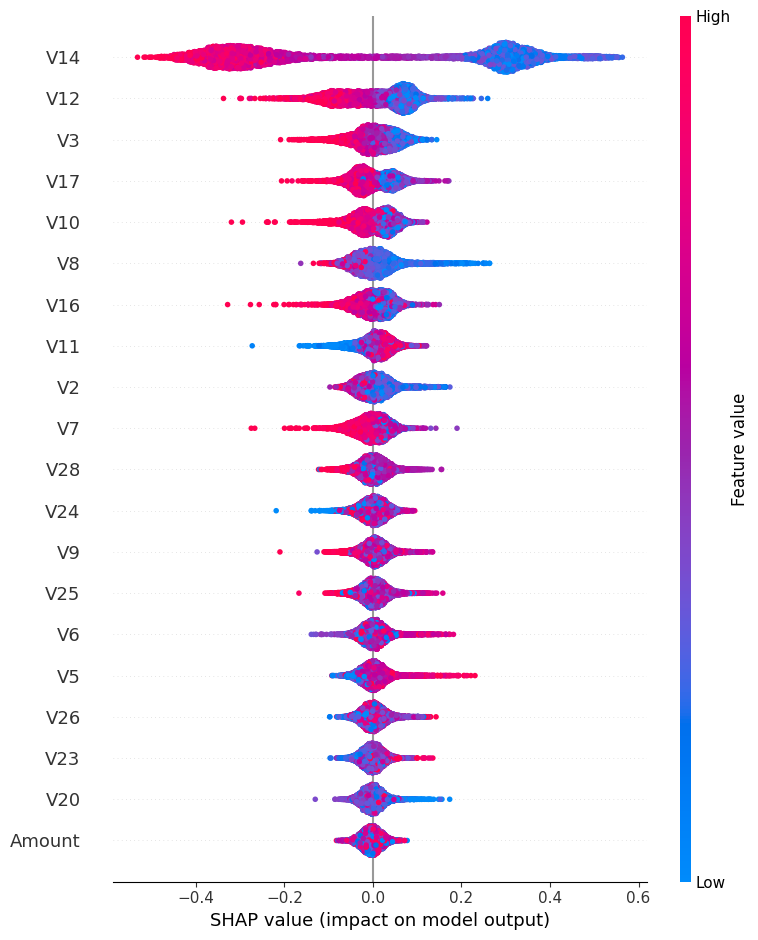

In [48]:
explainer = SSWARM(automl, random_state=77)
shapley_values = explainer.shap_values(test, n_repeats=5, n_jobs=N_THREADS)
shap.summary_plot(shapley_values[1], test[explainer.used_feats])